In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
import pyneb as pn


/home/mainak/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mainak/.local/lib/python2.7/site-packages/pyneb/utils/manage_atomic_data.py:528: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  gsconf = np.genfromtxt(execution_path('../atomic_data/levels/gsconfs.dat'), names=['atom', 'gsconf'], dtype=None)


In [2]:
def spec(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y):
    y = np.sum(np.sum(wo_cube[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2],axis=1),axis=1)
    y_err = np.sqrt(np.sum(np.sum(((wo_err[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2]))**2,axis=1),axis=1))
    return y,y_err

def SII_fit(wo_wave,data,error,z,p_init_SII):
    k = 1+z
    select = (wo_wave>6700*k) & (wo_wave < 6750*k)
    popt_full_fit,pcov_full_fit = leastsq(test_gauss_SII,x0=p_init_SII,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(test_gauss_SII,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
        parameters_err = np.std(parameters_MC,1)  
    (amp_SII6716_error,amp_SII6731_error,vel_SII6731_error,vel_sigma_SII6731_error,amp_SII6716_br_error,amp_SII6731_br_error,vel_SII6731_br_error,vel_sigma_SII6731_br_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

def coupled_fit(wo_wave,data,error,z,p_init_complex):
    k = 1+z
    select = (wo_wave>6400*k) & (wo_wave<6800*k)
    popt_full_fit,pcov_full_fit = leastsq(complex_gauss_coupled,x0=p_init_complex,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(complex_gauss_coupled,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    return popt_full_fit,parameters_err 

def decoupled_fit(wo_wave,data,error,z,p_init_fit):
    k = 1+z
    select = (wo_wave>6400*k) & (wo_wave<6800*k)
    popt_full_fit,pcov_full_fit = leastsq(complex_gauss_decoupled,x0=p_init_fit,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(complex_gauss_decoupled,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    return popt_full_fit,parameters_err 

In [3]:
def amp_complex_table(obj,amp_par,amp_par_err):
    column_names={'amp_SII6716_nr_ind':0,'amp_SII6731_nr_ind':1,'amp_SII6716_br_ind':2,'amp_SII6731_br_ind':3,'amp_Ha_nr_fix':4,'amp_NII6583_nr_fix':5,'amp_SII6716_nr_fix':6,'amp_SII6731_nr_fix':7,'amp_Ha_br_fix':8,'amp_NII6583_br_fix':9,'amp_SII6716_br_fix':10,'amp_SII6731_br_fix':11,'amp_Ha_nr_nonfix':12,'amp_NII6583_nr_nonfix':13,'amp_SII6716_nr_nonfix':14,
                 'amp_SII6731_nr_nonfix':15,'amp_Ha_br_nonfix':16,'amp_NII6583_br_nonfix':17,'amp_SII6716_br_nonfix':18,'amp_SII6731_br_nonfix':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[amp_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[amp_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_amp_par_compare.fits'%(obj),overwrite=True)

def Ne_wo_err_tab(obj,Ne_array):
    column_names={'Ne_nr_ind':0,'Ne_wing_ind':1,'Ne_core_fix':2,'Ne_wing_fix':3,'Ne_core_nonfix':4,'Ne_wing_nonfix':5}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[Ne_array[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_Ne_tab.fits'%(obj),overwrite=True)

def kin_SII_table(obj,kin_par,kin_par_err):
    column_names={'vel_SII_nr_ind':0,'vel_sigma_SII_nr_ind':1,'vel_SII_br_ind':2,'vel_sigma_SII_br_ind':3,'vel_SII_nr_fix':4,'vel_sigma_SII_nr_fix':5,'vel_SII_br_fix':6,
              'vel_sigma_SII_br_fix':7,'vel_SII_nr_nonfix':8,'vel_sigma_SII_nr_nonfix':9,'vel_SII_br_nonfix':10,'vel_sigma_SII_br_nonfix':11}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[kin_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[kin_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_kin_par_compare.fits'%(obj),overwrite=True)
    
def kin_Ha_NII_table(obj,kin_Ha_NII_par,kin_Ha_NII_par_err):
    column_names={'vel_Ha_nr_fix':0,'vel_sigma_Ha_nr_fix':1,'vel_Ha_br_fix':2,'vel_sigma_Ha_br_fix':3,'vel_Ha_nr_nonfix':4,'vel_sigma_Ha_nr_nonfix':5,'vel_Ha_br_nonfix':6,'vel_sigma_Ha_br_nonfix':7}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[kin_Ha_NII_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[kin_Ha_NII_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_kin_par_Ha_NII_compare.fits'%(obj),overwrite=True)
  

In [4]:
def algorithm_script(obj,z,p_init_SII,p_init_complex,prefix_path_cube="/home/mainak/xdata/ftp.hidrive.strato.com/users/login-carsftp"):
    print '%s'%(obj)
    try:
        (orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.binned.fits'%(prefix_path_cube,obj,obj))
    except IOError:
        (orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.unbinned.fits'%(prefix_path_cube,obj,obj))   
    (cont_cube,cont_err,cont_wave,cont_header) = loadCube('%s/MUSE/%s/%s.cont_model.fits'%(prefix_path_cube,obj,obj))
    (QSO_cube,QSO_err,QSO_wave,QSO_header) = loadCube('%s/MUSE/%s/%s.QSO_full.fits'%(prefix_path_cube,obj,obj))
    difference = difference_in_wavelength_dimension(orig_cube,cont_cube)
    (wo_cube,wo_err,wo_wave,wo_header) = create_wo_absorption_cube(obj,orig_cube,orig_err,orig_header,cont_cube,cont_wave,difference)
    
    #####################Get the integrated spectrum####################################################
    [brightest_pixel_x,brightest_pixel_y] = central_pixel(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(brightest_pixel_x),int(brightest_pixel_y)]
    (data,error) = spec(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y)
    k = 1+z
     
    ################# Perform the SII fit alone##############################################################
    (popt_SII_fit,parameters_err_SII) = SII_fit(wo_wave,data,error,z,p_init_SII)
    (amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,m_SII,c_SII) = popt_SII_fit
    (amp_SII6716_fit_err,amp_SII6731_fit_err,vel_SII6731_fit_err,vel_sigma_SII6731_fit_err,amp_SII6716_br_fit_err,amp_SII6731_br_fit_err,vel_SII6731_br_fit_err,vel_sigma_SII6731_br_fit_err,m_SII_err,c_SII_err) = parameters_err_SII

    ################# Check the lectron density for the independent fit####################
    (ratio_core_ind,ratio_wing_ind) = flux_ratio(amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit) 
    print (ratio_core_ind,ratio_wing_ind)  
    (Ne_core_ind, Ne_wing_ind) = electron_density(ratio_core_ind,ratio_wing_ind)    
    #(Ne_core_err_ind,Ne_wing_err_ind,low_ind,high_ind) = electron_density_err(amp_SII6716_fit,amp_SII6716_fit_err,amp_SII6731_fit,amp_SII6731_fit_err,amp_SII6716_br_fit,amp_SII6716_br_fit_err,amp_SII6731_br_fit,amp_SII6731_br_fit_err)
    print 'electron_density_core_indep_fit is',Ne_core_ind
    print 'electron_density_wing_indep_fit',Ne_wing_ind
    
    ################ Get the the corresponding error for the lectron density########################
    MC_loops = 800
    Ne_core_temp = np.zeros(MC_loops)
    Ne_wing_temp = np.zeros(MC_loops)
    for m in range(MC_loops):
        (core,wing) = flux_ratio(np.random.normal(amp_SII6716_fit,amp_SII6716_fit_err),np.random.normal(amp_SII6731_fit,amp_SII6731_fit_err),np.random.normal(amp_SII6716_br_fit,amp_SII6716_br_fit_err),np.random.normal(amp_SII6731_br_fit,amp_SII6731_br_fit_err))
        out = electron_density(core,wing)
        Ne_core_temp[m]=out[0]
        Ne_wing_temp[m]=out[1]
    Ne_wing_temp[Ne_wing_temp > 10000] = np.nan
    Ne_wing_temp = Ne_wing_temp[np.logical_not(np.isnan(Ne_wing_temp))]
    plt.hist(Ne_wing_temp)
    plt.xlabel('Electron Density(/cc)')
    plt.ylabel('Number of Electrons')
    plt.show()
    Ne_core_err = np.nanstd(Ne_core_temp)
    Ne_wing_err = np.nanstd(Ne_wing_temp)
    low = np.percentile(Ne_wing_temp,16)
    high = np.percentile(Ne_wing_temp,84)
    print 'electron_density_core is',Ne_core_ind, Ne_core_err
    print 'electron_density_wing is',Ne_wing_ind, Ne_wing_err
    
    #################### perform the fit with coupling H-alpha + [NII] kinematics with [SII]##########################
    (popt_coupled_fit,parameters_err_coupled) = coupled_fit(wo_wave,data,error,z,p_init_complex)
    print popt_coupled_fit
    plot_coupled_kin(obj,wo_wave,data,error,z,popt_coupled_fit)
    (amp_Ha_core_fit,amp_NII6583_core_fit,amp_SII6716_core_fit,amp_SII6731_core_fit,vel_core_fit,vel_sigma_core_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit,amp_SII6716_wing_fit,amp_SII6731_wing_fit,vel_wing_fit,vel_sigma_wing_fit,amp_Ha_blr1_fit,vel_blr1_fit,vel_sigma_blr1_fit,amp_Ha_blr2_fit,vel_blr2_fit,vel_sigma_blr2_fit,amp_Ha_blr3_fit,vel_blr3_fit,vel_sigma_blr3_fit,m_fit,c_fit)= popt_coupled_fit
    (amp_Ha_core_fit_err,amp_NII6583_core_fit_err,amp_SII6716_core_fit_err,amp_SII6731_core_fit_err,vel_core_fit_err,vel_sigma_core_fit_err,amp_Ha_wing_fit_err,amp_NII6583_wing_fit_err,amp_SII6716_wing_fit_err,amp_SII6731_wing_fit_err,vel_wing_fit_err,vel_sigma_wing_fit_err,amp_Ha_blr1_fit_err,vel_blr1_fit_err,vel_sigma_blr1_fit_err,amp_Ha_blr2_fit_err,vel_blr2_fit_err,vel_sigma_blr2_fit_err,amp_Ha_blr3_fit_err,vel_blr3_fit_err,vel_sigma_blr3_fit_err,m_fit_err,c_fit_err)= parameters_err_coupled
   
    ################# Check the lectron density for the coupled fit####################
    (ratio_core_coupled,ratio_wing_coupled) = flux_ratio(amp_SII6716_core_fit,amp_SII6731_core_fit,amp_SII6716_wing_fit,amp_SII6731_wing_fit) 
    print (ratio_core_coupled,ratio_wing_coupled)  
    (Ne_core_coupled, Ne_wing_coupled) = electron_density(ratio_core_coupled,ratio_wing_coupled)    
    #(Ne_core_err_coup,Ne_wing_err_coup,low_coup,high_coup) = electron_density_err(amp_SII6716_core_fit,amp_SII6716_core_fit_err,amp_SII6731_core_fit,amp_SII6731_core_fit_err,amp_SII6716_wing_fit,amp_SII6716_wing_fit_err,amp_SII6731_wing_fit,amp_SII6731_wing_fit_err)
    print 'electron_density_core_coupled is',Ne_core_coupled
    print 'electron_density_wing_coupled is',Ne_wing_coupled
        
    ############### Use the previous fit parameters(some) to fit the H-alpha + [NII] ++ decoupled [SII]#################
    p_init_fit = (amp_Ha_core_fit,amp_NII6583_core_fit,vel_core_fit,vel_sigma_core_fit,amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit,vel_wing_fit,vel_sigma_wing_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,amp_Ha_blr1_fit,vel_blr1_fit,vel_sigma_blr1_fit,amp_Ha_blr2_fit,vel_blr2_fit,vel_sigma_blr2_fit,amp_Ha_blr3_fit,vel_blr3_fit,vel_sigma_blr3_fit,-2.19991913e+00,2.46898420e+01)
    #print 'fit parameters guess is', p_init_fit
    (popt_decoupled_fit,parameters_err_decoupled) = decoupled_fit(wo_wave,data,error,z,p_init_fit)
    print popt_decoupled_fit
    plot_decoupled_kin(obj,wo_wave,data,error,z,popt_decoupled_fit)
    (amp_Ha_core,amp_NII6583_core,vel_Ha_core,vel_sigma_Ha_core,amp_SII6716_core,amp_SII6731_core,vel_SII6731_core,vel_sigma_SII6731_core,amp_Ha_wing,amp_NII6583_wing,vel_Ha_wing,vel_sigma_Ha_wing,amp_SII6716_wing,amp_SII6731_wing,vel_SII6731_wing,vel_sigma_SII6731_wing,amp_Ha_blr1,vel_blr1,vel_sigma_blr1,amp_Ha_blr2,vel_blr2,vel_sigma_blr2,amp_Ha_blr3,vel_blr3,vel_sigma_blr3,m,c)= popt_decoupled_fit
    (amp_Ha_core_err,amp_NII6583_core_err,vel_Ha_core_err,vel_sigma_Ha_core_err,amp_SII6716_core_err,amp_SII6731_core_err,vel_SII6731_core_err,vel_sigma_SII6731_core_err,amp_Ha_wing_err,amp_NII6583_wing_err,vel_Ha_wing_err,vel_sigma_Ha_wing_err,amp_SII6716_wing_err,amp_SII6731_wing_err,vel_SII6731_wing_err,vel_sigma_SII6731_wing_err,amp_Ha_blr1_err,vel_blr1_err,vel_sigma_blr1_err,amp_Ha_blr2_err,vel_blr2_err,vel_sigma_blr2_err,amp_Ha_blr3_err,vel_blr3_err,vel_sigma_blr3_err,m_err,c_err)= parameters_err_decoupled

    ############# Get the electron density##############################################################
    (ratio_core,ratio_wing) = flux_ratio(amp_SII6716_core,amp_SII6731_core,amp_SII6716_wing,amp_SII6731_wing) 
    print (ratio_core,ratio_wing)  
    (Ne_core, Ne_wing) = electron_density(ratio_core,ratio_wing)    
    print 'electron_density_core is',Ne_core
    print 'electron_density_wing is',Ne_wing
    
     ################ Get the the corresponding error for the lectron density########################
    MC_loops = 800
    Ne_core_temp = np.zeros(MC_loops)
    Ne_wing_temp = np.zeros(MC_loops)
    for m in range(MC_loops):
        (core,wing) = flux_ratio(np.random.normal(amp_SII6716_core,amp_SII6716_core_err),np.random.normal(amp_SII6731_core,amp_SII6731_core_err),np.random.normal(amp_SII6716_wing,amp_SII6716_wing_err),np.random.normal(amp_SII6731_wing,amp_SII6731_wing_err))
        out = electron_density(core,wing)
        Ne_core_temp[m]=out[0]
        Ne_wing_temp[m]=out[1]
    Ne_wing_temp[Ne_wing_temp > 10000] = np.nan
    Ne_wing_temp = Ne_wing_temp[np.logical_not(np.isnan(Ne_wing_temp))]
    plt.hist(Ne_wing_temp)
    plt.xlabel('Electron Density(/cc)')
    plt.ylabel('Number of Electrons')
    plt.show()
    Ne_core_err = np.nanstd(Ne_core_temp)
    Ne_wing_err = np.nanstd(Ne_wing_temp)
    low = np.percentile(Ne_wing_temp,16)
    high = np.percentile(Ne_wing_temp,84)
    print 'electron_density_core is',Ne_core, Ne_core_err
    print 'electron_density_wing is',Ne_wing, Ne_wing_err
        
    ################ Create the table of amplitudes of H-alpha, NII and SII##################################
    amp_par = [amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,amp_Ha_core_fit,amp_NII6583_core_fit,amp_SII6716_core_fit,amp_SII6731_core_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit,amp_SII6716_wing_fit,amp_SII6731_wing_fit,amp_Ha_core,amp_NII6583_core,amp_SII6716_core,amp_SII6731_core,amp_Ha_wing,amp_NII6583_wing,amp_SII6716_wing,amp_SII6731_wing]
    amp_par_err = [amp_SII6716_fit_err,amp_SII6731_fit_err,amp_SII6716_br_fit_err,amp_SII6731_br_fit_err,amp_Ha_core_fit_err,amp_NII6583_core_fit_err,amp_SII6716_core_fit_err,amp_SII6731_core_fit_err,amp_Ha_wing_fit_err,amp_NII6583_wing_fit_err,amp_SII6716_wing_fit_err,amp_SII6731_wing_fit_err,amp_Ha_core_err,amp_NII6583_core_err,amp_SII6716_core_err,amp_SII6731_core_err,amp_Ha_wing_err,amp_NII6583_wing_err,amp_SII6716_wing_err,amp_SII6731_wing_err]
    amp_complex_table(obj,amp_par,amp_par_err)
    
    ############## Create the table of SII kinematic parameter################################################
    kin_par = [vel_SII6731_fit,vel_sigma_SII6731_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,vel_core_fit,vel_sigma_core_fit,vel_wing_fit,vel_sigma_wing_fit,vel_SII6731_core,vel_sigma_SII6731_core,vel_SII6731_wing,vel_sigma_SII6731_wing]
    kin_par_err = [vel_SII6731_fit_err,vel_sigma_SII6731_fit_err,vel_SII6731_br_fit_err,vel_sigma_SII6731_br_fit_err,vel_core_fit_err,vel_sigma_core_fit_err,vel_wing_fit_err,vel_sigma_wing_fit_err,vel_SII6731_core_err,vel_sigma_SII6731_core_err,vel_SII6731_wing_err,vel_sigma_SII6731_wing_err]
    kin_SII_table(obj,kin_par,kin_par_err)
    
    ############ Create the table of Ha+[NII] kinematic parameters###########################################
    kin_Ha_NII_par = [vel_core_fit,vel_sigma_core_fit,vel_wing_fit,vel_sigma_wing_fit,vel_Ha_core,vel_sigma_Ha_core,vel_Ha_wing,vel_sigma_Ha_wing]
    kin_Ha_NII_par_err = [vel_core_fit_err,vel_sigma_core_fit_err,vel_wing_fit_err,vel_sigma_wing_fit_err,vel_Ha_core_err,vel_sigma_Ha_core_err,vel_Ha_wing_err,vel_sigma_Ha_wing_err]
    kin_Ha_NII_table(obj,kin_Ha_NII_par,kin_Ha_NII_par_err)
    
    ############## Create the table of electron density###################################################
    Ne_array = [Ne_core_ind,Ne_wing_ind,Ne_core_coupled,Ne_wing_coupled,Ne_core,Ne_wing]
    Ne_wo_err_tab(obj,Ne_array)

In [ ]:
z = {"HE0433-1028":0.035550} # 3 BLR
objs = z.keys()
p_init_complex = {'HE0433-1028':(20,15,5,5,10665,50,5,8,2,2,10365,100,5,10665,1000,5,10665,1500,0,10665,1500,-0.001,0.1)}
p_init_SII = {'HE0433-1028':(5,5,10665,50,2,2,10365,300,-0.001,0.1)}
#b =[(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf), (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]

for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 


HE0433-1028


HE0040-1105
(1.058014355342035, 0.640453249854897)
electron_density_core_indep_fit is 393.19892809774234
electron_density_wing_indep_fit 2421.857530843653


/home/mainak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


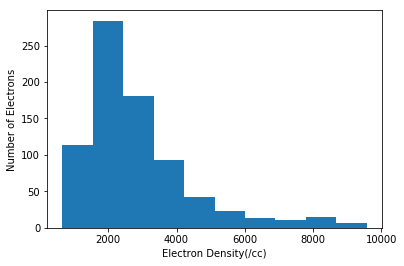

electron_density_core is 393.19892809774234 11.305149934565726
electron_density_wing is 2421.857530843653 1584.756598324987
[ 6.96475307e+00  3.51400975e+00  1.70927415e+00  1.65218542e+00
  1.26334228e+04  7.56291838e+01  3.51637827e+00  5.45445689e-01
  1.72342179e-01  1.32735086e-01  1.25043735e+04  2.94947140e+02
  4.12887014e+00  1.29767858e+04  6.74881802e+02  4.28594152e+00
  1.29248053e+04  1.27871391e+03  5.41247788e-01  1.33077856e+04
  4.27896673e+03 -1.77082876e-01  3.03222466e+00]


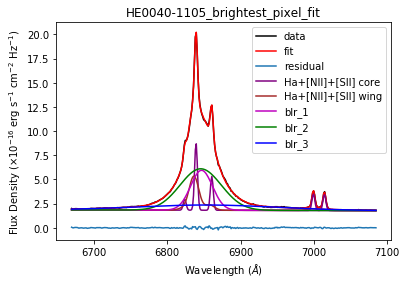

(1.0345534675569692, 1.2983920364777617)
electron_density_core_coupled is 431.47772764515423
electron_density_wing_coupled is 110.04647108675937
[ 7.02626319e+00  3.51261739e+00  1.26298607e+04  7.88779134e+01
  1.75615658e+00  1.65779705e+00  1.26379289e+04  7.33788910e+01
  3.45997437e+00  4.73785649e-01  1.25014201e+04  3.08177679e+02
  1.68140158e-01  1.81229620e-01  1.24348333e+04  2.55187311e+02
  4.03072595e+00  1.29930866e+04  6.71684461e+02  4.32544838e+00
  1.29217092e+04  1.27596551e+03  5.40465913e-01  1.33139476e+04
  4.30083911e+03 -1.75001846e-01  3.01699634e+00]


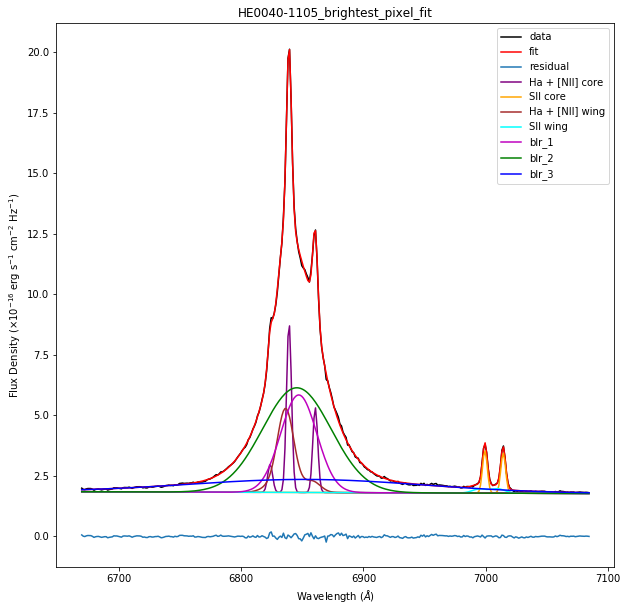

(1.0593314677242172, 0.9277741604954199)
electron_density_core is 390.83026885118045
electron_density_wing is 659.6351418581642


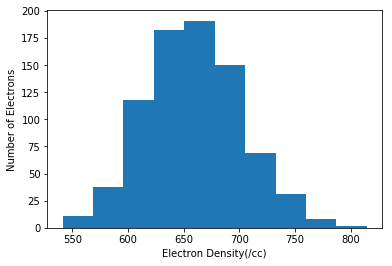

electron_density_core is 390.83026885118045 14.184317502183191
electron_density_wing is 659.6351418581642 42.68388419033794


In [6]:
z = {"HE0040-1105":0.04196} # 3 BLR

objs = z.keys()
#p_init_complex = {'HE0040-1105':(7.4,3.8,1.8,1.7,12507,80,0.9,0.9,0.1,0.2,12260,300,7.5,12507,800,2.5,12507,1500,0,12607,800,-0.25,3.64)}
p_init_complex = {'HE0040-1105':(7,3.5,1.7,1.6,12630,70,1,1,0.15,0.2,12530,200,7.5,12600,500,2.5,12600,1000,0,12588,1500,-0.25,3.64)}
#p_init_complex = {'HE0040-1105':[6.96471997e+00,3.51393225e+00,1.70927660e+00,1.65218495e+00,1.26334223e+04,7.56285389e+01,3.51667979e+00,5.45669944e-01,1.72341427e-01,1.32737222e-01,1.25043857e+04,2.94961370e+02,4.12860073e+00,1.29768031e+04,6.74881841e+02,5.41235240e-01,1.33079048e+04,4.27880332e+03,4.28588952e+00,1.29247991e+04,1.27871842e+03,-1.77146104e-01,3.03267625e+00]}
p_init_SII = {'HE0040-1105':[1.87694146e+00,1.77111167e+00,1.25815027e+04,7.96934769e+01,1.28586194e-01,1.88260735e-01,1.22677663e+04,1.08495375e+02,-4.17013743e+00,3.11638372e+01]}

for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 

HE0253-1641
(1.187554201824752, 0.5454052352994487)
electron_density_core_indep_fit is 218.3168685963021
electron_density_wing_indep_fit 4944.522987966364


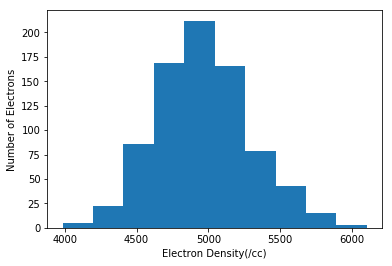

electron_density_core is 218.3168685963021 7.0618103117308415
electron_density_wing is 4944.522987966364 329.29476160710504
[ 2.96443592e+01  3.51134150e+01  9.56903614e+00  9.59041983e+00
  9.58708798e+03  8.82268065e+01  1.67294473e+01  1.34220028e+01
  2.14381083e+00  3.97569213e+00  9.41250656e+03  2.12200838e+02
  5.36116920e+01  9.70098456e+03  5.91237322e+02  1.43878151e+01
  9.40986125e+03  1.68311706e+03  0.00000000e+00  9.57600000e+03
  1.50000000e+03 -6.56599100e+00  6.80130346e+01]


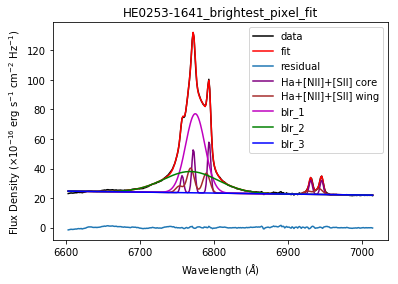

(0.9977703074376698, 0.5392295885072819)
electron_density_core_coupled is 501.83590264719095
electron_density_wing_coupled is 5240.608156687242
[ 3.14666735e+01  3.71002739e+01  9.58686911e+03  8.88295567e+01
  8.82241167e+00  8.50385493e+00  9.59064683e+03 -8.87123576e+01
  1.50694719e+01  1.13363913e+01  9.39231923e+03  1.84720037e+02
  2.51006004e+00  4.04446981e+00  9.47115677e+03  2.35432428e+02
  5.56272209e+01  9.70260775e+03  6.02813272e+02  1.39235925e+01
  9.39926198e+03  1.71060857e+03  0.00000000e+00  9.57600000e+03
  1.50000000e+03 -6.60888859e+00  6.82707371e+01]


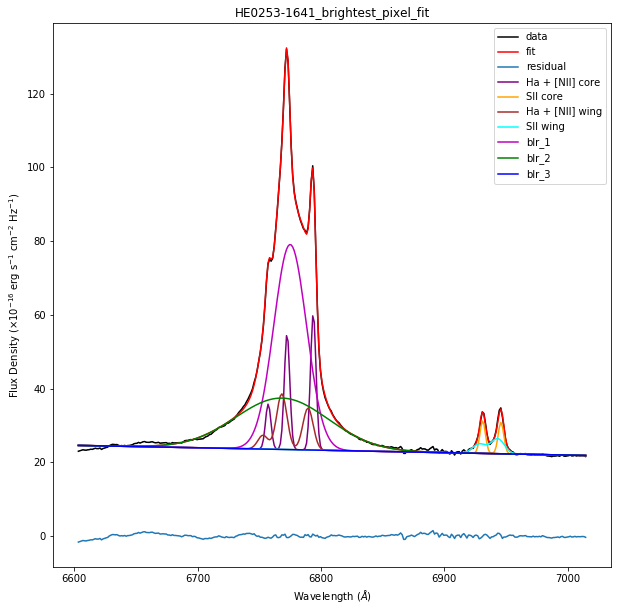

(1.0374602749621364, 0.6206153479939311)
electron_density_core is 426.93931472726655
electron_density_wing is 2739.146864432323


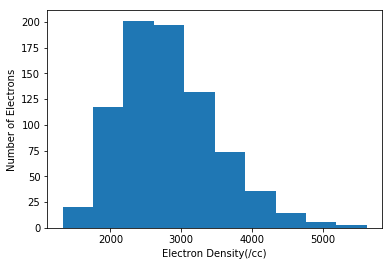

electron_density_core is 426.93931472726655 41.83718416760085
electron_density_wing is 2739.146864432323 682.3085806956535


In [6]:
z = {"HE0253-1641":0.031588} # 2 broad components
objs = z.keys()
p_init_complex = {'HE0253-1641':(34,40,9,11,9476,88,20,20,4,5,9400,100,5,9476,500,5,9576,1500,0,9576,1500,-0.001,0.1)}

p_init_SII = {'HE0253-1641':[5,5,9476,50,2,2,9276,100,-0.001,0.1]}



for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 

HE0224-2834
(1.193981973868053, 0.6037195046461169)
electron_density_core_indep_fit is 211.18086157626112
electron_density_wing_indep_fit 3072.3724431682713


/home/mainak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


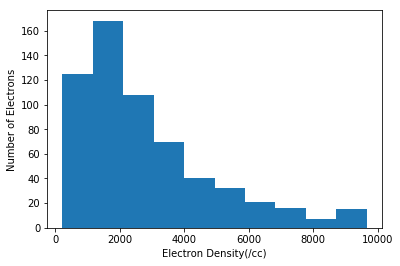

electron_density_core is 211.18086157626112 62.10386045506286
electron_density_wing is 3072.3724431682713 2056.3648316431377
[ 6.06763743e+00  3.60040032e+00  1.49911296e+00  1.32318062e+00
  1.80117884e+04  1.24906480e+02  2.75943525e+00  1.89888739e+00
 -3.26993925e-02  9.76002327e-02  1.77451874e+04  4.11304892e+02
  8.57289837e+00  1.80597068e+04  1.82826506e+03  1.37704841e+00
  1.78536627e+04  4.29782156e+03  1.22431732e+00  1.58965393e+04
  7.02486641e+02 -1.13954889e-01  3.47298721e+00]


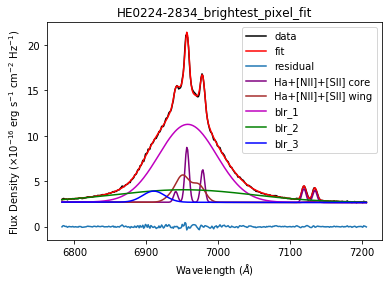

(1.1329616910408395, -0.3350339602106828)
electron_density_core_coupled is 284.5910023501971
electron_density_wing_coupled is nan
[ 6.04807094e+00  3.64191416e+00  1.80069567e+04  1.25270092e+02
  1.39426842e+00  1.16249886e+00  1.80421785e+04  1.30495088e+02
  2.74125772e+00  1.85311999e+00  1.77475822e+04  4.32064012e+02
  2.48045623e-01  4.35677991e-01  1.79304554e+04  5.43324438e+01
  8.53939838e+00  1.80638354e+04  1.83714178e+03  1.35017295e+00
  1.78131702e+04  4.38680294e+03  1.24871846e+00  1.58955586e+04
  6.99651615e+02 -8.05305168e-02  3.22740235e+00]


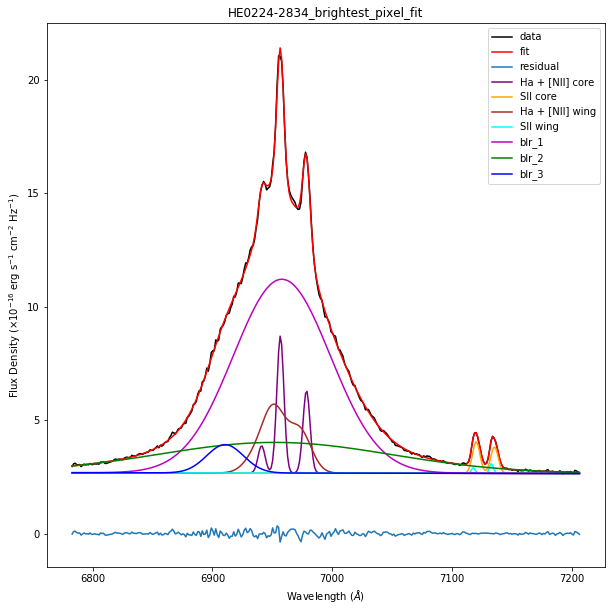

(1.199371852846273, 0.5693324607879411)
electron_density_core is 204.8961925303414
electron_density_wing is 3983.9292375482337


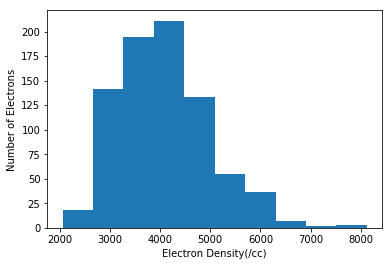

electron_density_core is 204.8961925303414 12.17596172948063
electron_density_wing is 3983.9292375482337 909.9931720716316


In [7]:
z = {"HE0224-2834":0.059800}

objs = z.keys()
p_init_complex = {'HE0224-2834':(7.73464616e+00,4.66433887e+00,1.38842632e+00,1.15867721e+00,1.79970055e+04,1.55926920e+02,1.37282949e+00,1.49219726e+00,1.56013290e-01,4.43751497e-01,1.75056209e+04,1.47701968e+02,8.53939894e+00,1.80638353e+04,1.85992138e+03,1.35017295e+00,1.78131705e+04,4.38680257e+03,1.24871789e+00,1.58955585e+04,6.99651402e+02,-8.05307185e-02,3.22740383e+00)}
#p_init_complex = {'HE0040-1105':(7,4,1.8,1.7,12507,80,1,1,0.1,0.2,12307,3040,7.5,12507,800,2.5,12507,1500,0,0,0,-0.25,3.64)}
p_init_SII = {'HE0224-2834':[1.28347008e+00,1.08543217e+00,1.80556524e+04,1.23064387e+02,3.99785108e-01,5.61026655e-01,1.79296652e+04,6.42081964e+01,-6.73939395e+00,5.09879797e+01]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 

HE0108-4743
(1.2307930248401306, 1.0105907351479393)
electron_density_core_indep_fit is 171.96260170078793
electron_density_wing_indep_fit 475.99299083563744


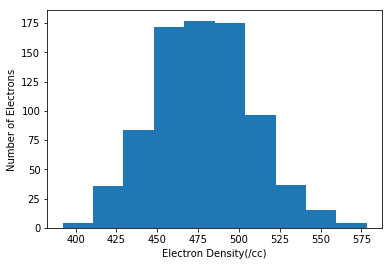

electron_density_core is 171.96260170078793 25.557152293395458
electron_density_wing is 475.99299083563744 29.649327537985815
[ 4.86702855e+01  3.04659271e+01  8.91144906e+00  7.32571041e+00
  7.23627064e+03  4.91894736e+01  1.58569369e+01  7.04447473e+00
  8.32826657e-01  9.91732021e-01  7.17402591e+03  1.49830929e+02
  3.79351748e+00  7.19894847e+03  1.41566767e+03  1.97150473e+01
  7.21299410e+03  4.91976914e+02  0.00000000e+00  7.28000000e+03
  1.00000000e+03 -1.09124419e+00  1.24589659e+01]


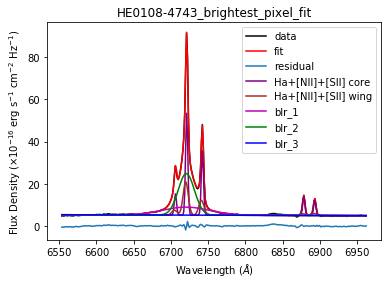

(1.2164620982734264, 0.839769856713773)
electron_density_core_coupled is 187.7085036595387
electron_density_wing_coupled is 938.6152301253138
[ 4.87129514e+01  3.04921259e+01  7.23647035e+03  4.83285556e+01
  6.09209158e+00  5.13565771e+00  7.23983709e+03  4.26730587e+01
  1.61460985e+01  7.14882098e+00  7.17444785e+03  1.51678501e+02
  3.46576576e+00  3.09225781e+00  7.21221939e+03  8.90110522e+01
  3.75596188e+00  7.19603294e+03  1.42003681e+03  1.96017689e+01
  7.21307748e+03  4.93408650e+02  0.00000000e+00  7.28000000e+03
  1.00000000e+03 -1.07205960e+00  1.23315921e+01]


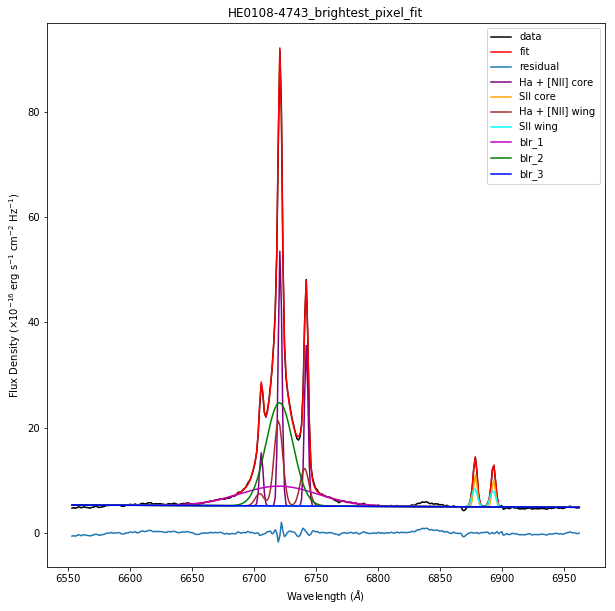

(1.1862339609791732, 1.1207880987399983)
electron_density_core is 219.30846432559773
electron_density_wing is 300.4957747219075


/home/mainak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in greater


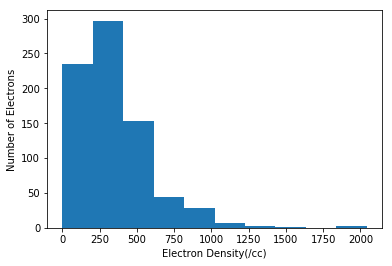

electron_density_core is 219.30846432559773 114.29469001441085
electron_density_wing is 300.4957747219075 249.06178605278873


In [5]:
z = {"HE0108-4743":0.02392}

objs = z.keys()
#p_init_complex = {'HE0040-1105':(7.4,3.8,1.8,1.7,12507,80,0.9,0.9,0.1,0.2,12260,300,7.5,12507,800,2.5,12507,1500,0,12607,800,-0.25,3.64)}
p_init_complex = {'HE0108-4743':(50,30,7,5,7180,50,15,8,2,2,7162,140,10,7180,1000,5,7180,1000,0,7280,1000,1,-2.0)}

p_init_SII = {'HE0108-4743':[7.01139742e+00,5.43164916e+00,7.17994835e+03,4.46217177e+01,2.54039101e+00,2.83827138e+00,7.16191480e+03,1.02056476e+02,-1.01400110e+01,7.46809874e+01]}

for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 


HE0119-0118
(1.0338087703198446, 0.8788534958439571)
electron_density_core_indep_fit is 433.4375004962859
electron_density_wing_indep_fit 800.9475620609466


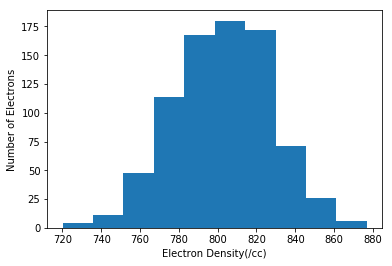

electron_density_core is 433.4375004962859 11.915848359983267
electron_density_wing is 800.9475620609466 24.503674938215454
[ 3.56857953e+01  2.40484037e+01  5.64705277e+00  6.22840210e+00
  1.64028865e+04  8.26034597e+01  1.75045292e+01  1.81113343e+01
  1.59697525e+00  1.97047885e+00  1.61288863e+04  2.72641317e+02
  1.89928504e+00  1.25946928e+04  1.03512652e+03  3.97054434e+00
  1.72749030e+04  3.52994135e+03  2.34196593e+01  1.65753318e+04
  1.55812424e+03 -4.07867312e+00  3.63131700e+01]


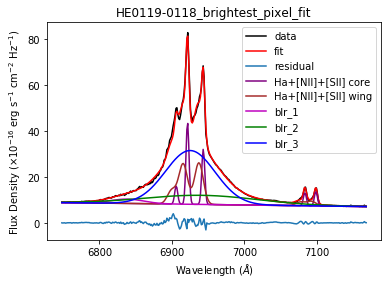

(0.9066615600393203, 0.8104503378221148)
electron_density_core_coupled is 717.8631463901995
electron_density_wing_coupled is 1059.181224036792
[ 3.60998278e+01  2.47657342e+01  1.63993142e+04  8.63548301e+01
  5.96666038e+00  5.77329401e+00  1.64219437e+04  7.05692541e+01
  1.71262786e+01  1.77894096e+01  1.61093369e+04  2.82039189e+02
  2.52608480e+00  2.82111575e+00  1.62162866e+04  1.83282293e+02
  1.93839722e+00  1.26301007e+04  1.05230001e+03  3.51457520e+00
  1.74025983e+04  3.89261469e+03  2.35026224e+01  1.65942750e+04
  1.58345844e+03 -4.07892273e+00  3.62161170e+01]


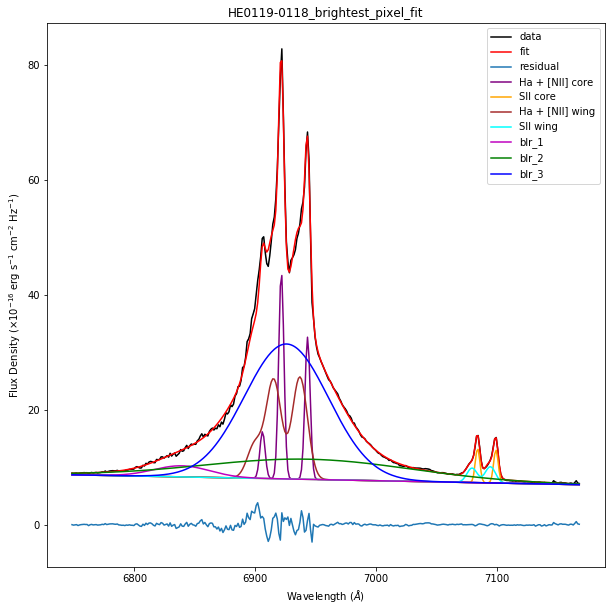

(1.0334932492618156, 0.8954204722256346)
electron_density_core is 434.748958401199
electron_density_wing is 750.0092650949582


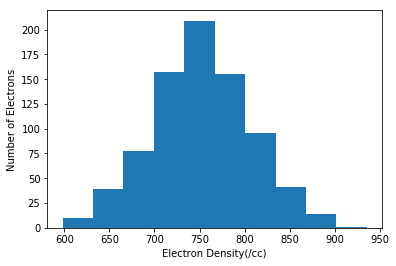

electron_density_core is 434.748958401199 32.06408054483769
electron_density_wing is 750.0092650949582 54.41519985697495


In [8]:
z = {"HE0119-0118":0.054341} 
objs = z.keys()
p_init_fit = {'HE0119-0118':(23,23,5,5,16302,50,5,8,2,2,16102,100,5,16302,1500,5,16302,1500,5,16302,1500,-0.001,0.1)}
p_init_SII = {'HE0119-0118':(5,5,16302,50,2,2,16102,100,-0.001,0.1)}

for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_fit[obj]) 


HE1353-1917
(1.27774703655735, 19.557269454186372)
electron_density_core_indep_fit is 127.89437661791163
electron_density_wing_indep_fit nan


/home/mainak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


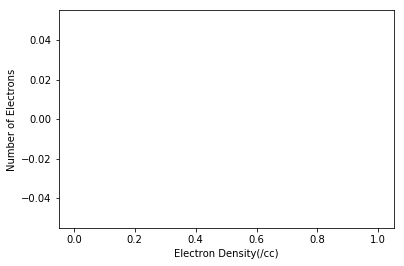

IndexError: cannot do a non-empty take from an empty axes.

In [8]:
z = {"HE1353-1917":0.035021} 
objs = z.keys()
p_init_fit = {'HE1353-1917':(23,23,5,5,10563,50,5,8,2,2,10263,100,5,10563,1500,5,10563,1500,5,10563,1500,-0.001,0.1)}
p_init_SII = {'HE1353-1917':(5,5,10563,100,2,2,9963,300,-0.001,0.1)}

for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_fit[obj]) 
